In [280]:
import sys
print(sys.executable)

/Users/coricampbell/Documents/hockey_analyses/.venv/bin/python


In [281]:
# =============================
# Reqs/setup
# =============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from datetime import datetime

from pathlib import Path

pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda x: f"{x:.3f}")

In [282]:
# NHL API URL
BASE_URL = "https://api-web.nhle.com/v1"

# Test connection
response = requests.get(f"{BASE_URL}/standings/now")
print(f"Status Code: {response.status_code}")
print("API is working!" if response.status_code == 200 else "API error")

Status Code: 200
API is working!


In [283]:
# =============================
# Data Paths
# =============================

DATA_DIR = Path("/Users/coricampbell/Documents/HALO_hackathon/data/")

events_path = DATA_DIR / "events.parquet"
games_path = DATA_DIR / "games.parquet"
players_path = DATA_DIR / "players.parquet"
stints_path = DATA_DIR / "stints.parquet"
tracking_path = DATA_DIR / "tracking.parquet"

In [284]:
# =============================
# Load Data
# =============================

events = pd.read_parquet(events_path)
games = pd.read_parquet(games_path)
players = pd.read_parquet(players_path)
stints = pd.read_parquet(stints_path)
tracking = pd.read_parquet(tracking_path)

print("Events:", events.shape)
print("Games:", games.shape)
print("Players:", players.shape)
print("Stints:", stints.shape)
print("Tracking:", tracking.shape)

Events: (1800464, 24)
Games: (480, 12)
Players: (1172, 8)
Stints: (2212064, 15)
Tracking: (13529224, 10)



Games details:
There are 32 teams in the leagues(s): ['AHL'].
Events details:
There are 36 types of events with 3: [None 'failed' 'successful' 'undetermined'], with tracking data avilable for outcomes as follows: has_tracking_data
1   0.903
0   0.097
Name: proportion, dtype: float64.
Event frequencies are as follows: event_type
pass                     0.224
lpr                      0.188
reception                0.169
carry                    0.061
failedpasslocation       0.054
faceoff                  0.047
block                    0.037
puckprotection           0.030
shot                     0.030
pressure                 0.030
controlledentryagainst   0.021
dumpout                  0.020
dumpin                   0.019
dumpinagainst            0.018
whistle                  0.014
check                    0.014
penalty                  0.006
goal                     0.003
controlledbreakout       0.003
assist                   0.003
icing                    0.002
penaltydrawn      

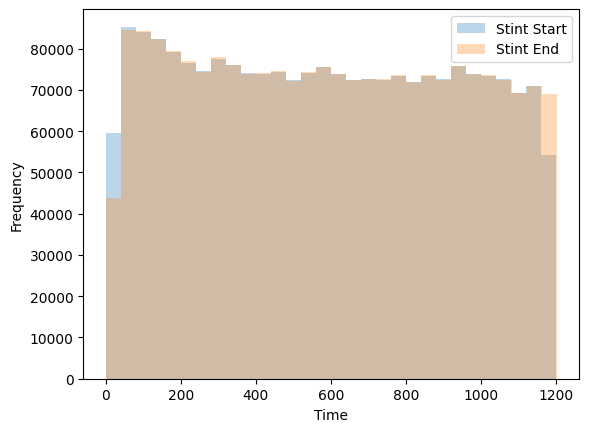


Tracking details:
The number of rows missing values for variables is as follows: x-tracking: 0.0; x-tracking velocity: 0.02756292600373828: y-tracking: 0.0; y-tracking velocity: 0.02756292600373828; SL event ID: 0.0


In [285]:
# =============================
# Exploration (minimal)
# =============================

# Games
games.head()
teams_tot = games['home_team'].nunique() 
leagues = games["league"].unique()
print("\nGames details:")
print(f"There are {teams_tot} teams in the leagues(s): {leagues}.")
games[["home_score", "away_score"]].max().max()  # max 8 goal win i
games['home_team'].nunique()  #  32 teams in league

# Events
unique_events = events["event_type"].nunique()  # types of events
outcomes_unique = events["outcome"].nunique()  # event outcomes
outcomes_types = events["outcome"].unique()  # types of outcomes
print("Events details:")
tracking_data = events["has_tracking_data"].value_counts(normalize=True)  # Most events (>90%) have tracking data, don't impute missing
print(f"There are {unique_events} types of events with {outcomes_unique}: {outcomes_types}, with tracking data avilable for outcomes as follows: {tracking_data}.")
event_freq = events["event_type"].value_counts(normalize=True)
print(f"Event frequencies are as follows: {event_freq}")
pass_detail_prop = (
    events.loc[events["event_type"] == "pass", "detail"]
          .value_counts(normalize=True)
)
print(f"Pass type frequencies are as follows: {pass_detail_prop}")

# Players
unique_players = players["player_id"].nunique()
print("\nPlayers details:")
print(f"There are {unique_players} players in the league.")

# Stints (shifts). Game stints triggered when player enters or leaves the ice
print("\nStints/shifts details:")
print("Nothing remarkeable to note. Useful to investigate penalties (info on number of skaters on ice available).")

plt.hist(stints["period_time_start"], bins=30, alpha=0.3, label="Stint Start")
plt.hist(stints["period_time_end"], bins=30, alpha=0.3, label="Stint End")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

# Tracking (shifts)
tracking.head()
tracking.columns
missing_x_vel_tracking = tracking["tracking_vel_x"].isna().mean()
missing_x_tracking = tracking["tracking_x"].isna().mean()
missing_y_vel_tracking = tracking["tracking_vel_y"].isna().mean()
missing_y_tracking = tracking["tracking_y"].isna().mean()
missing_eventID_tracking = tracking["sl_event_id"].isna().mean()

print("\nTracking details:")
print(f"The number of rows missing values for variables is as follows: x-tracking: {missing_x_tracking}; x-tracking velocity: {missing_x_vel_tracking}: y-tracking: {missing_y_tracking}; y-tracking velocity: {missing_y_vel_tracking}; SL event ID: {missing_eventID_tracking}")


In [286]:
## Subset `events` object to defensive passes

# Defensive zone threshold (adjust if needed
DZ_THRESHOLD = -25

dz_passes = (
    events
    .query("event_type == 'pass'") # Subset to passes
    .query("detail in ['d2d', 'd2doffboards', 'outlet', 'outletoffboards', 'stretch', 'stretchoffboards', 'ozentrystretch', 'ozentrystretchoffboards']") # Subset to defensive passes
    .query("x_adj < @DZ_THRESHOLD") # subset rows to defensive zone
    .copy()
)

dz_passes.shape


(172452, 24)

In [287]:
# Investigate success rates of different defensive pass types 

pass_overall_breakdown = dz_passes["detail"].value_counts(normalize=True)
dz_passes["outcome"].value_counts(normalize=True)

pass_by_success_breakdown = pd.crosstab(
    dz_passes["detail"],
    dz_passes["outcome"],
    normalize="index"
)

print(f"The breakdown of defensive pass type frequencies overall is as follows: {pass_overall_breakdown}. ")
print(f"\nThe breakdown of defensive pass type frequencies stratified by pass success is as follows: {pass_by_success_breakdown}.")

The breakdown of defensive pass type frequencies overall is as follows: detail
outlet                    0.335
d2d                       0.275
d2doffboards              0.157
outletoffboards           0.137
stretch                   0.064
stretchoffboards          0.026
ozentrystretch            0.004
ozentrystretchoffboards   0.002
Name: proportion, dtype: float64. 

The breakdown of defensive pass type frequencies stratified by pass success is as follows: outcome                  failed  successful  undetermined
detail                                                   
d2d                       0.123       0.877         0.000
d2doffboards              0.265       0.735         0.000
outlet                    0.241       0.759         0.000
outletoffboards           0.390       0.609         0.001
ozentrystretch            0.336       0.664         0.000
ozentrystretchoffboards   0.369       0.631         0.000
stretch                   0.366       0.634         0.000
stretchoffboards

In [288]:
# Merge tracking for all players involved in these events
dz_tracking = dz_passes[["game_id", "sl_event_id", "player_id"]].merge(
    tracking,
    on=["game_id", "sl_event_id"],
    how="left"
)

dz_tracking.head()

# Identify passer rows
dz_tracking["is_passer"] = dz_tracking["player_id_x"] == dz_tracking["player_id_y"]

In [289]:
### Compute distance to passer

# Extract passer coordinates per event
passer_coords = (
    dz_tracking[dz_tracking["is_passer"]][["game_id", "sl_event_id", "tracking_x", "tracking_y"]]
    .rename(columns={"tracking_x": "passer_x", "tracking_y": "passer_y"})
)

# Merge back to compute distance from passer for all players
dz_tracking = dz_tracking.merge(
    passer_coords,
    on=["game_id", "sl_event_id"],
    how="left"
)

# Compute distance to passer 
# TODO confirm computation
dz_tracking["dist_to_passer"] = np.sqrt(
    (dz_tracking["tracking_x"] - dz_tracking["passer_x"])**2 +
    (dz_tracking["tracking_y"] - dz_tracking["passer_y"])**2
)





<Axes: >

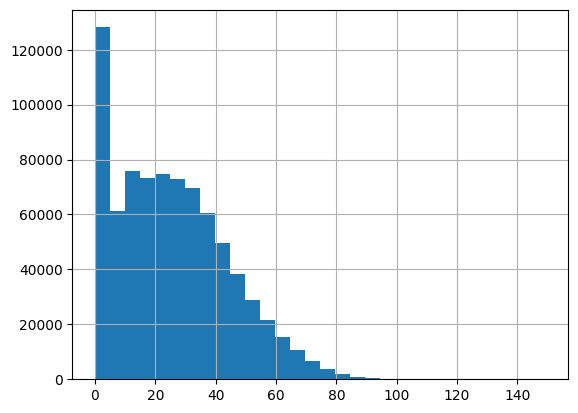

In [290]:
# Visualize distance to passer values
dz_tracking["dist_to_passer"].hist(bins=30)

In [291]:
# Identify Opponents

dz_tracking.columns

Index(['game_id', 'sl_event_id', 'player_id_x', 'team_id', 'team_name',
       'player_id_y', 'player_name', 'tracking_x', 'tracking_y',
       'tracking_vel_x', 'tracking_vel_y', 'is_passer', 'passer_x', 'passer_y',
       'dist_to_passer'],
      dtype='object')

In [292]:
### Identify opponents 

#  Build event to passer_team_id mapping
passer_lookup = (
    dz_tracking.loc[dz_tracking["is_passer"], 
                    ["game_id", "sl_event_id", "team_id"]]
    .drop_duplicates(subset=["game_id", "sl_event_id"])
    .set_index(["game_id", "sl_event_id"])["team_id"]
)

# Map passer team back to all rows
dz_tracking["passer_team_id"] = list(
    zip(dz_tracking["game_id"], dz_tracking["sl_event_id"])
)
dz_tracking["passer_team_id"] = dz_tracking["passer_team_id"].map(passer_lookup)

# Identify opponents
dz_tracking["is_opponent"] = (
    dz_tracking["team_id"] != dz_tracking["passer_team_id"]
)

dz_tracking.columns



Index(['game_id', 'sl_event_id', 'player_id_x', 'team_id', 'team_name',
       'player_id_y', 'player_name', 'tracking_x', 'tracking_y',
       'tracking_vel_x', 'tracking_vel_y', 'is_passer', 'passer_x', 'passer_y',
       'dist_to_passer', 'passer_team_id', 'is_opponent'],
      dtype='object')

In [293]:
dz_tracking.head()

,game_id,sl_event_id,player_id_x,team_id,team_name,player_id_y,player_name,tracking_x,tracking_y,tracking_vel_x,tracking_vel_y,is_passer,passer_x,passer_y,dist_to_passer,passer_team_id,is_opponent
0,00b0366a-95c6-5250-2dae-e3dd5c4198bc,11,8682f8c1-304a-51d9-6663-158ca58fa6c9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,True
1,00b0366a-95c6-5250-2dae-e3dd5c4198bc,15,cb8a6b8b-c5a6-4bfe-10b7-15c784b83a7d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,True
2,00b0366a-95c6-5250-2dae-e3dd5c4198bc,17,0753b094-9e2f-976d-85c8-d22a1d280e8d,d7ff41e7-8310-f2ab-3c79-6ad3d1f4f019,Monsters,0753b094-9e2f-976d-85c8-d22a1d280e8d,"Jiricek, David",64.708,-21.230,-8.957,-18.996,True,64.708,-21.230,0.000,d7ff41e7-8310-f2ab-3c79-6ad3d1f4f019,False
3,00b0366a-95c6-5250-2dae-e3dd5c4198bc,17,0753b094-9e2f-976d-85c8-d22a1d280e8d,6cac12e2-0546-2c1a-689f-ab26d8a6355a,Griffins,663df049-a045-0561-16e3-1db633a0723e,"Aston-Reese, Zachary",62.238,-1.243,-5.512,-12.992,False,64.708,-21.230,20.139,d7ff41e7-8310-f2ab-3c79-6ad3d1f4f019,True
4,00b0366a-95c6-5250-2dae-e3dd5c4198bc,17,0753b094-9e2f-976d-85c8-d22a1d280e8d,d7ff41e7-8310-f2ab-3c79-6ad3d1f4f019,Monsters,None,None,85.482,-0.276,-0.394,-0.394,False,64.708,-21.230,29.507,d7ff41e7-8310-f2ab-3c79-6ad3d1f4f019,False


In [294]:

# Event-Level Pressure Summary
pressure_summary = (
    dz_tracking
    .query("is_opponent == True")
    .groupby(["game_id", "sl_event_id"])
    .agg(
        nearest_defender=("dist_to_passer", "min"),
        defenders_within_3m=("dist_to_passer", lambda x: (x < 3).sum())
    )
    .reset_index()
)

dz_passes = dz_passes.merge(
    pressure_summary,
    on=["game_id", "sl_event_id"],
    how="left"
)


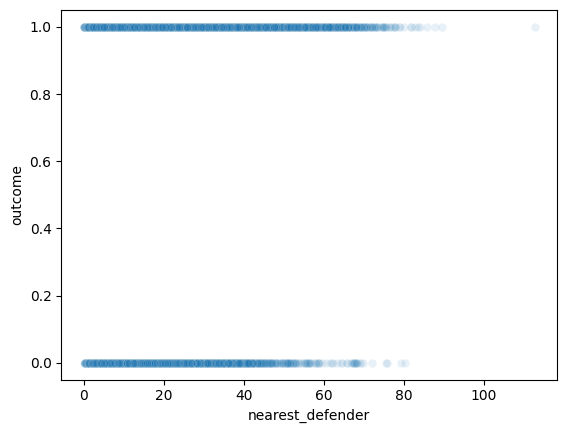

In [295]:
# Investigation I: Does Pressure Matter? - Exploration

sns.scatterplot(
    data=dz_passes,
    x="nearest_defender",
    y=(dz_passes["outcome"] == "successful").astype(int),
    alpha=0.1
)
plt.show()

In [ ]:
# Investigation I: Does Pressure Matter? - Exploration
dz_passes["success"] = (dz_passes["outcome"] == "successful").astype(int)

dz_passes["pressure_bin"] = pd.cut(
    dz_passes["nearest_defender"],
    bins=[0,1,2,3,5,10,50]
)

pressure_effect = (
    dz_passes
    .groupby("pressure_bin")
    .success
    .mean()
    .reset_index()
)

pressure_effect

/var/folders/gc/zrfyxv5d77l_myrgcgyt_4f40000gn/T/ipykernel_55285/4060799969.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dz_passes


,pressure_bin,success
0,"(0, 1]",0.776
1,"(1, 2]",0.709
2,"(2, 3]",0.728
3,"(3, 5]",0.711
4,"(5, 10]",0.695
5,"(10, 50]",0.780


In [297]:
# Test system hypothesis:

team_context = (
    dz_passes
    .groupby("team_id")
    .agg(
        avg_nearest_defender=("nearest_defender", "mean"),
        pct_high_pressure=("nearest_defender", lambda x: (x < 2).mean()),
        raw_success=("success", "mean")
    )
    .sort_values("avg_nearest_defender")
)

team_context.head(teams_tot)

,avg_nearest_defender,pct_high_pressure,raw_success
team_id,,,
9bfe142b-8c31-828f-dde8-a252d75d5ef3,11.805,0.007,0.755
411d86dc-8d7b-5507-c28d-87aa160b61cc,11.839,0.009,0.739
be8d53f2-8cbd-df04-b9e7-0eb07a851c0a,11.896,0.008,0.766
800ae5b7-9166-d248-f73d-c4d16fd1b4d6,12.019,0.010,0.730
9c9ce715-dcef-1692-1850-eba56333387b,12.028,0.010,0.762
28147617-6a1a-8547-8b07-b84f5d0807c5,12.046,0.009,0.745
94373660-74b2-7b92-acca-ac87ea867b06,12.226,0.009,0.761
e3572140-5df5-e208-74d8-cb1a581d5fba,12.241,0.010,0.729
67c5ed49-a598-0057-310c-c709186007ab,12.293,0.007,0.745


In [ ]:
# Quantify multicollinearity between "nearest_defender" and "defenders_within_3m"

dz_passes[["nearest_defender", "defenders_within_3m"]].corr()

,nearest_defender,defenders_within_3m
nearest_defender,1.000,-0.259
defenders_within_3m,-0.259,1.000


In [ ]:
# Explore success prob across pass types and pressure bands

pd.crosstab(
    dz_passes["pressure_bin"],
    dz_passes["detail"],
    values=dz_passes["success"],
    aggfunc="mean"
).fillna(0)

detail,d2d,d2doffboards,outlet,outletoffboards,ozentrystretch,ozentrystretchoffboards,stretch,stretchoffboards
pressure_bin,,,,,,,,
"(0, 1]",0.867,0.800,0.769,0.628,0.000,0.000,0.000,1.000
"(1, 2]",0.791,0.748,0.623,0.612,0.000,0.000,0.286,0.500
"(2, 3]",0.808,0.741,0.689,0.624,1.000,0.500,0.593,0.690
"(3, 5]",0.790,0.716,0.694,0.628,0.750,0.600,0.516,0.527
"(5, 10]",0.792,0.726,0.689,0.600,0.574,0.591,0.563,0.581
"(10, 50]",0.914,0.777,0.801,0.623,0.642,0.607,0.647,0.598


In [307]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Features and target
features = ["nearest_defender", "defenders_within_3m", "detail", "team_id",  "period_time"]
target = "success"

# Drop rows with missing target or features
dz_model_data = dz_passes[features + [target]].dropna()

X = dz_model_data[features]
y = dz_model_data[target]

# Identify categorical features
categorical_features = ["detail", "team_id"]
numeric_features = ["nearest_defender", "defenders_within_3m", "period_time"]

# Fix for player IDs that are not included in both train and test sets
OneHotEncoder(drop="first", handle_unknown="ignore")

# Column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features)
    ]
)

# Logistic regression pipeline
pipeline = Pipeline([
    ("preproc", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit model
pipeline.fit(X_train, y_train)

# Predictions and probabilities
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC: {auc:.3f}")

# Optional: create dataframe of predicted probabilities
dz_model_data_test = X_test.copy()
dz_model_data_test["actual_success"] = y_test
dz_model_data_test["predicted_prob"] = y_prob

dz_model_data_test.head()


Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.66      0.45      5268
           1       0.82      0.55      0.66     15198

    accuracy                           0.58     20466
   macro avg       0.58      0.61      0.55     20466
weighted avg       0.70      0.58      0.60     20466

ROC AUC: 0.649


/Users/coricampbell/Documents/hockey_analyses/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,nearest_defender,defenders_within_3m,detail,team_id,period_time,actual_success,predicted_prob
21063,5.253,0.000,outletoffboards,2fddd6bd-144f-ca64-90e3-8d36f96c8b28,171.970000000,0,0.325
7357,12.594,0.000,outlet,50030ea0-2c9b-66e2-a36c-bab16b79492c,309.730000000,1,0.498
155217,7.010,0.000,outletoffboards,9c9ce715-dcef-1692-1850-eba56333387b,624.370000000,0,0.343
86058,2.926,1.000,outletoffboards,411d86dc-8d7b-5507-c28d-87aa160b61cc,945.130000000,1,0.306
156317,10.537,0.000,outlet,f630ab4e-2bc7-6672-9c9c-4a4c835b198c,481.530000000,0,0.452
